In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import cv2
import torch

import random
import os

from pathlib import Path
import sys

from glob import glob
from PIL import Image

from fastai.vision.all import *
%matplotlib inline

'''
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
'''

'\nimport torch.nn as nn\nimport torch.nn.functional as F\nfrom torchvision.datasets import ImageFolder\nfrom torchvision.transforms import ToTensor\nfrom torch.utils.data import random_split\nfrom torchvision.utils import make_grid\nfrom torch.utils.data.dataloader import DataLoader\n'

In [3]:
SEED = 4

In [4]:
path = 'drive/My Drive/Genpact Project/obj_1'

In [28]:
images = []
paths = []
for image in os.listdir(path):
  image_path = os.path.join(path,image)
  im = cv2.imread(image_path)
  #k = im[:, :, 0]
  norm_image = cv2.normalize(im, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  t = torch.Tensor(np.array(norm_image))
  paths.append( int(image[6:-4] ) )
  images.append(t.permute(2,0,1).float()) 

In [6]:
def binning(z):
  bins = np.linspace(0, 180, 37)
  bins_index= np.linspace(0, 37 -1, 37)
  y = np.zeros(37)
  index = int(np.interp( z, bins, bins_index))
  y[index] = 1
  if index-1 >= 0 and index + 1 < 37:
    y[index-1] = 0.89
    y[index+1] = 0.89
    if index - 2 >= 0 and index + 2 < 37:
      y[index-2] = 0.61
      y[index+2] = 0.61
      if index - 3 >= 0 and index + 3 < 37:
        y[index-3] = 0.32
        y[index+3] = 0.32
        if index - 4 >= 0 and index + 4 < 37:
          y[index-4] = 0.1
          y[index+4] = 0.1
  return y

In [7]:
df = []
for i in range(len(images)):
  for j in range(len(images)):
    angle = min( (360 - abs( paths[i] - paths[j] ) )  , abs( paths[i] - paths[j] ) )
    if angle > 25:
      k = torch.tensor(0)    # If the difference is above 25, Then it's "Not Duplicate" so 0.
    if angle <= 25:         # If the difference is below 25, The it's a "Duplicate" so 1.
      k = torch.tensor(1)
    new = [ images[i], images[j], k]
    
    df.append(new)      

In [8]:
random.seed(SEED)
random.shuffle(df)

In [9]:
cut = int(len(df) * 0.8 )
train = df[ :cut]
valid = df[cut:]

In [10]:
len(train), len(valid)

(4147, 1037)

In [12]:
from fastai.data.core import DataLoaders

dls = DataLoaders.from_dsets(train, valid) 
dls = dls.cuda()

In [13]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [14]:
model_meta[resnet34] 

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [15]:
encoder = create_body(resnet34, cut=-2)
encoder[-1] 

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [27]:
head = create_head(512*4, 2, ps=0.5) 
model = SiameseModel(encoder, head)

In [18]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [19]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [20]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=accuracy)  

In [21]:
learn.freeze() 

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.17378008365631104)

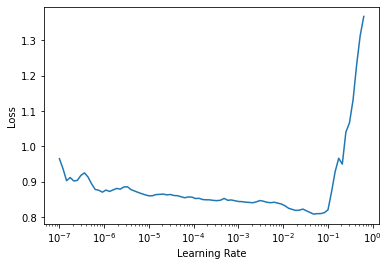

In [22]:
learn.lr_find() 

In [24]:
learn.fit_one_cycle(10, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.719133,0.510200,0.749277,00:11
1,0.429490,0.273509,0.901639,00:11
2,0.254593,0.147598,0.931533,00:11
3,0.176682,0.130608,0.944069,00:11
4,0.131631,0.104468,0.959499,00:11
5,0.118415,0.082607,0.959499,00:11
6,0.098457,0.078799,0.965284,00:11
7,0.089886,0.056967,0.971070,00:11
8,0.071270,0.050524,0.976856,00:11
9,0.058938,0.051097,0.972999,00:11


In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(10, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.056731,0.049544,0.975892,00:15
1,0.046105,0.046723,0.976856,00:15
2,0.051555,0.047826,0.982642,00:15
3,0.052833,0.048902,0.972999,00:15
4,0.045175,0.049209,0.973963,00:15
5,0.048829,0.045812,0.980714,00:15
6,0.049372,0.045329,0.975892,00:15
7,0.047239,0.044722,0.976856,00:15
8,0.046231,0.045262,0.977821,00:15
9,0.044286,0.045843,0.975892,00:15
